In [55]:
import math
import tqdm
import numpy as np
import pandas as pd
import datetime

import torch
import gpytorch
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split


### DATASET:

In [34]:
import os

daily_chains = {}

for file in os.listdir('../option_data/spy_data'):
    if file[-4:] == '.csv':
                
        df = pd.read_csv('../option_data/spy_data/' + file)    
        
        # moving to datetime and making features
        df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
        df['expiration'] = pd.to_datetime(df['expiration'])
        df['quote_date'] = df['quote_datetime'][0].date()
        df['quote_date'] = pd.to_datetime(df['quote_date'])
        
        # getting only 4:00 quotes
        eod = datetime.datetime.combine(df['quote_datetime'][0].date(), datetime.time(16,0, 0))
        df = df.loc[df['quote_datetime'] == eod]
        
        # getting time to expiration and moneyness
        df['T'] = df['expiration'] - df['quote_date']
        df['T'] = df['T'].dt.days
        df['moneyness'] = df['active_underlying_price'] / df['strike'] 
        
        # converting to ML features
        df['mny'] = df['moneyness'].astype(np.float32)
        df['iv'] = df['implied_volatility'].astype(np.float32)
        
        # filtering for research paper criteria
        df = df.loc[(df['close']!=0) & 
                    (df['iv']!=0) & (df['T']>=20) & 
                    (df['T']<=365) & 
                    (df['mny']>0.7) & (df['mny']<1.3) &
                    (df['bid_size']!=0) & df['ask_size']!=0]
                
        # splitting up into calls/puts
        calls = df.loc[df['option_type']=='C'][['T', 'mny', 'bid_size', 'bid', 'ask_size', 'ask', 'iv']].astype(np.float32)
        puts = df.loc[df['option_type']=='P'][['T', 'mny', 'bid_size', 'bid', 'ask_size', 'ask', 'iv']].astype(np.float32)
        opts = {'calls':calls, 'puts':puts}
    
        # assinging to date
        daily_chains[file[-14:-4]] = opts 

In [156]:
_ = [print(k) for k in sorted(daily_chains.keys())]

2023-10-02
2023-10-03
2023-10-04
2023-10-05
2023-10-06
2023-10-09
2023-10-10
2023-10-11
2023-10-12
2023-10-13
2023-10-16
2023-10-17
2023-10-18
2023-10-19
2023-10-20
2023-10-23
2023-10-24
2023-10-25
2023-10-26
2023-10-27
2023-10-30
2023-10-31


### Model Setup
#### Feature Extractor:

In [177]:
# HARDCODED
data_dim = 5 #train_x.size(-1) 

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 100))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(100, 20))
        self.add_module('relu2', torch.nn.ReLU())
        #self.add_module('linear3', torch.nn.Linear(500, 50))
        #self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(20, 2))

feature_extractor = LargeFeatureExtractor()

#### DKL-GP

In [178]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Training on each day

In [185]:
gp_models = {}
#likelihood = gpytorch.likelihoods.GaussianLikelihood()

for day, options in daily_chains.items():
    
    info = {}
    
    # calls and puts
    c = options['calls']
    p = options['puts']
    
    # feature transformations
    c['mm_T'] = (c['T'] - 20)/(365-20)
    c['mm_mny'] = (c['mny'] - 0.7)/(1.3-0.7)
    c['ln_iv'] = np.log(c['iv'])
    c['ln_bsz'] = np.log(c['bid_size'])
    c['ln_asz'] = np.log(c['ask_size'])
    c['ln_spread'] = np.log(c['ask'] - c['bid'])
    
     # feature transformations
    p['mm_T'] = (p['T'] - 20)/(365-20)
    p['mm_mny'] = (p['mny'] - 0.7)/(1.3-0.7)
    p['ln_iv'] = np.log(p['iv'])
    p['ln_bsz'] = np.log(p['bid_size'])
    p['ln_asz'] = np.log(p['ask_size'])
    p['ln_spread'] = np.log(p['ask'] - p['bid'])

    # train test split
    c_train, c_test = train_test_split(c, test_size=0.2)
    p_train, p_test = train_test_split(p, test_size=0.2)
    info['call_train'] = c_train
    info['call_test'] = c_test
    info['put_train'] = p_train
    info['put_test'] = p_test

    # into tensors
    x_features = ['mm_T', 'mm_mny', 'ln_bsz', 'ln_asz', 'ln_spread']
    cx_train = torch.tensor(c_train[x_features].values)
    cy_train = torch.tensor(c_train[['ln_iv']].values).reshape(len(c_train))
    cx_test = torch.tensor(c_test[x_features].values)
    cy_test = torch.tensor(c_test[['ln_iv']].values).reshape(len(c_test))
    
    px_train = torch.tensor(p_train[x_features].values)
    py_train = torch.tensor(p_train[['ln_iv']].values).reshape(len(p_train))
    px_test = torch.tensor(p_test[x_features].values)
    py_test = torch.tensor(p_test[['ln_iv']].values).reshape(len(p_test))
    
    # initializing likelihood and model
    c_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    c_model = GPRegressionModel(cx_train, cy_train, c_likelihood)
    
    p_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    p_model = GPRegressionModel(px_train, py_train, p_likelihood)

    # Find optimal model hyperparameters
    c_model.train()
    c_likelihood.train()
    
    p_model.train()
    p_likelihood.train()

    # Use the adam optimizer
    c_optimizer = torch.optim.Adam([
        {'params': c_model.feature_extractor.parameters()},
        {'params': c_model.covar_module.parameters()},
        {'params': c_model.mean_module.parameters()},
        {'params': c_model.likelihood.parameters()},
    ], lr=0.05)
    p_optimizer = torch.optim.Adam([
        {'params': p_model.feature_extractor.parameters()},
        {'params': p_model.covar_module.parameters()},
        {'params': p_model.mean_module.parameters()},
        {'params': p_model.likelihood.parameters()},
    ], lr=0.05)

    # "Loss" for GPs - the marginal log likelihood
    c_mll = gpytorch.mlls.ExactMarginalLogLikelihood(c_likelihood, c_model)
    p_mll = gpytorch.mlls.ExactMarginalLogLikelihood(p_likelihood, p_model)

    c_losses = []
    p_losses = []
    
    def train_calls():
        for i in range(500):
            # Zero backprop gradients
            c_optimizer.zero_grad()
            # Get output from model
            c_output = c_model(cx_train)
            # Calc loss and backprop derivatives
            c_loss = -c_mll(c_output, cy_train)
            c_loss.backward()
            c_optimizer.step()
            
            c_losses.append(c_loss.item())
            
    def train_puts():
        for i in range(500):
            # Zero backprop gradients
            p_optimizer.zero_grad()
            # Get output from model
            p_output = p_model(px_train)
            # Calc loss and backprop derivatives
            p_loss = -p_mll(p_output, py_train)
            p_loss.backward()
            p_optimizer.step()
            
            p_losses.append(p_loss.item())

    print('STARTING CALL MODEL TRAINING FOR', day)
    train_calls()
    
    print('STARTING PUT MODEL TRAINING FOR', day)
    train_puts()

    info['call_losses'] = c_losses
    info['put_losses'] = p_losses

    # Get into evaluation (predictive posterior) mode
    c_model.eval()
    c_likelihood.eval()
    
    p_model.eval()
    p_likelihood.eval()

    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        c_preds = c_model(cx_test)
        p_preds = p_model(px_test)

    info['call_preds'] = c_preds
    info['put_preds'] = p_preds        

    # rmse
    c_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** c_preds.mean - math.e ** cy_test, 2)))
    p_rmse = torch.sqrt(torch.mean(torch.pow(math.e ** p_preds.mean - math.e ** py_test, 2)))
    info['call_RMSE'] = c_rmse
    info['put_RMSE'] = p_rmse
    
    # saving the model
    torch.save(c_model, 'models/call_DKLGP_'+day+'.pt')
    torch.save(p_model, 'models/put_DKLGP_'+day+'.pt')
    
    # saving likelihood
    info['call_likelihood'] = c_likelihood
    info['put_likelihood'] = p_likelihood
    
    gp_models[day] = info  
    break
        

STARTING CALL MODEL TRAINING FOR 2023-10-09
STARTING PUT MODEL TRAINING FOR 2023-10-09


In [183]:
# TO BEAT: .0032, .0038
print('call rmse:', c_rmse)
print('put rmse:', p_rmse)

call rmse: tensor(0.0122)
put rmse: tensor(0.0111)


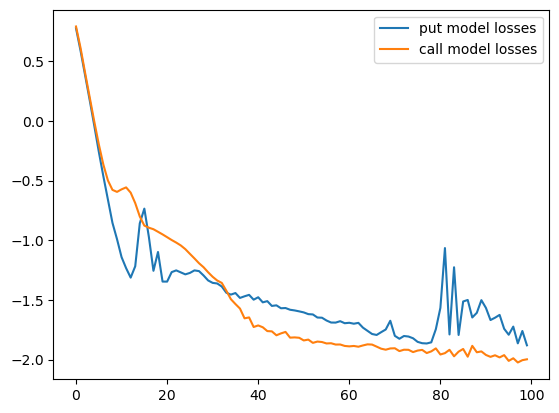

In [184]:
plt.plot(range(len(p_losses)), p_losses, label='put model losses')
plt.plot(range(len(c_losses)), c_losses, label='call model losses')

plt.legend()
plt.show()

#### Predicting

In [167]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(test_x))
    preds = model(test_x)

In [162]:
rmse = torch.sqrt(torch.mean(torch.pow(math.e ** preds.mean - math.e ** test_y, 2)))

rmse

tensor(0.0017)

In [79]:
t_to_exp = 25

# getting training/test data
c_tr = c_train
c_tr = c_tr.loc[c_tr['T']==t_to_exp]
c_tst = c_test
c_tst = c_tst.loc[c_tst['T']==t_to_exp]

model.eval()
likelihood.eval()

# 
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    tst_preds = model(test_x)
    


/Users/adammoszczynski/miniforge3/envs/vol2/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


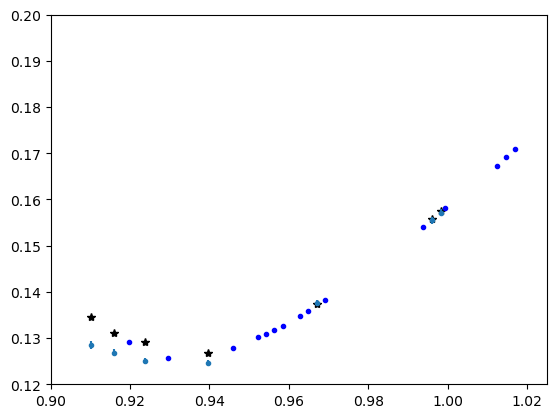

In [150]:
upper, lower = tst_preds.confidence_region()
upper = upper.numpy()
lower = lower.numpy()

plt.plot(c_tst['mny'], c_tst['iv'], 'k*')
plt.plot(c_tr['mny'], c_tr['iv'], 'b.')

ind = test_x[:, 0]==(25-20)/(345)
pred_iv = np.array(math.e ** tst_preds.mean[ind])
err = np.stack((pred_iv - math.e ** upper[ind], math.e ** lower[ind] - pred_iv))

plt.errorbar(c_tst['mny'], pred_iv, yerr=err, fmt='.')



plt.xlim(0.9, 1.025)
plt.ylim(0.120, 0.2)
plt.show()

